In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from compute_transport import *
import torch
import torch.nn.functional as F
from evaluation_metrics import *

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(20, 10), facecolor='white')

-----
anndata     0.11.3
scanpy      1.10.4
-----
PIL                         11.1.0
anyio                       NA
appnope                     0.1.2
asttokens                   NA
attr                        24.3.0
attrs                       24.3.0
babel                       2.16.0
backports                   NA
brotli                      1.0.9
certifi                     2025.01.31
charset_normalizer          3.3.2
comm                        0.2.1
compute_transport           NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.11
decorator                   5.1.1
defusedxml                  0.7.1
einops                      0.8.1
evaluation_metrics          NA
exceptiongroup              1.2.0
executing                   0.8.3
fastjsonschema              NA
h5py                        3.12.1
idna                        3.7
ipykernel                   6.29.5
ipywidgets                  8.1.5
ja

/Users/muqiao/miniforge3/envs/torch_env/lib/python3.10/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


In [3]:
df_ms = pd.read_pickle('ms_df_rgc.pkl')
df_ms

_index,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
25,0,0,0,0,0,0,0,0,0,0,...,0.849207,1.301712,0,0,0,0,0,0,0.849207,0
3,0,0,0,0,0,0.729256,0,0,0,0,...,1.146473,1.666602,0,0,0.729256,0,0.729256,0,0.729256,0
28,0,0,1.052499,0.658763,0.658763,0.658763,0,0,0,0,...,2.135255,2.018471,0,0,0,1.052499,0.658763,0,1.553841,0
28,0,0,0.571013,0.571013,0.571013,0.932211,0.571013,0,0,0,...,0,1.579041,0.571013,0,0,0.571013,0.932211,0,0,0
14,0,0,0,0.957386,0.957386,0.957386,0.589141,0,0,0,...,1.225926,2.004114,0,0,0,0.957386,0.957386,0,1.437405,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0,0,0.333,0,0.781818,0.333,0.582381,0,0,0,...,1.747768,2.311386,0.582381,0,0.333,0.948018,1.090492,0,0.582381,0
2,0,0,0.877586,0,0.877586,0,0.877586,0,0,0,...,1.337675,2.382837,0.877586,0,0,0,1.337675,0,1.337675,0
15,0,0,0,0.42069,0.715899,0.42069,0.42069,0,0,0,...,2.054016,1.910007,0,0,0,0,1.420231,0,0.42069,0


In [4]:
# transform cell type index into a number between 100 and 200
df_ms.index = df_ms.index+1
df_ms.index = df_ms.index+100
df_ms

_index,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
126,0,0,0,0,0,0,0,0,0,0,...,0.849207,1.301712,0,0,0,0,0,0,0.849207,0
104,0,0,0,0,0,0.729256,0,0,0,0,...,1.146473,1.666602,0,0,0.729256,0,0.729256,0,0.729256,0
129,0,0,1.052499,0.658763,0.658763,0.658763,0,0,0,0,...,2.135255,2.018471,0,0,0,1.052499,0.658763,0,1.553841,0
129,0,0,0.571013,0.571013,0.571013,0.932211,0.571013,0,0,0,...,0,1.579041,0.571013,0,0,0.571013,0.932211,0,0,0
115,0,0,0,0.957386,0.957386,0.957386,0.589141,0,0,0,...,1.225926,2.004114,0,0,0,0.957386,0.957386,0,1.437405,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,0,0.333,0,0.781818,0.333,0.582381,0,0,0,...,1.747768,2.311386,0.582381,0,0.333,0.948018,1.090492,0,0.582381,0
103,0,0,0.877586,0,0.877586,0,0.877586,0,0,0,...,1.337675,2.382837,0.877586,0,0,0,1.337675,0,1.337675,0
116,0,0,0,0.42069,0.715899,0.42069,0.42069,0,0,0,...,2.054016,1.910007,0,0,0,0,1.420231,0,0.42069,0


In [5]:
df_mk = pd.read_pickle('mk_df_rgc.pkl')
df_mk

,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
MG_OFF,0,0,0.4879,0.4879,0,0.814383,0,0,0,0,...,1.060105,0.814383,0.4879,0,0,0,1.060105,0,0,0
MG_OFF,0,0,0,0.919196,0.561692,0,0.919196,0,0,0,...,1.561965,1.708707,0.919196,0.561692,0,0,0,0,0.561692,0
PG_OFF,0,0,0.53539,0.53539,0.882208,0.303106,1.018951,0,0,0,...,0.72376,1.431869,0.53539,0.303106,0,0.303106,0.53539,0,0.53539,0
PG_ON,0,0,0,0.872852,0,1.331695,0,0,0,0,...,1.331695,2.075514,0,0,0.872852,0,0,0,0,0
MG_ON,0,0,0.488507,0,0.488507,0,0,0,0,0,...,0.81526,1.564292,0.81526,0,0.81526,0.81526,1.258326,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MG_ON,0,0,0,0.554216,1.169918,0.554216,0.908723,0,0,0,...,0.554216,1.694414,0.908723,0,0.554216,0.554216,0,0,1.169918,0
MG_OFF,0,0,0.991651,0.756335,0,0,0,0,0,0,...,0.991651,0.756335,0,0,0.448031,0,0.756335,0,0,0
MG_OFF,0,0,0,0.774602,1.205808,0,0.774602,0,0,0,...,1.736759,1.205808,0,0,0.774602,0,0,0,0,0


In [6]:
# Generate unique mapping for index values
unique_index_values = df_mk.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_mk.index = df_mk.index.map(index_mapping)
df_mk

Mapping of annotated values to numbers:
{'MG_OFF': 0, 'PG_OFF': 1, 'PG_ON': 2, 'MG_ON': 3, 'fRGC5': 4, 'fRGC8': 5, 'fRGC6': 6, 'fRGC9': 7, 'fRGC10': 8, 'fRGC11': 9, 'fRGC7': 10, 'fRGC13': 11, 'fRGC12': 12, 'fRGC15': 13, 'fRGC16': 14, 'fRGC14': 15}


,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
0,0,0,0.4879,0.4879,0,0.814383,0,0,0,0,...,1.060105,0.814383,0.4879,0,0,0,1.060105,0,0,0
0,0,0,0,0.919196,0.561692,0,0.919196,0,0,0,...,1.561965,1.708707,0.919196,0.561692,0,0,0,0,0.561692,0
1,0,0,0.53539,0.53539,0.882208,0.303106,1.018951,0,0,0,...,0.72376,1.431869,0.53539,0.303106,0,0.303106,0.53539,0,0.53539,0
2,0,0,0,0.872852,0,1.331695,0,0,0,0,...,1.331695,2.075514,0,0,0.872852,0,0,0,0,0
3,0,0,0.488507,0,0.488507,0,0,0,0,0,...,0.81526,1.564292,0.81526,0,0.81526,0.81526,1.258326,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0,0,0,0.554216,1.169918,0.554216,0.908723,0,0,0,...,0.554216,1.694414,0.908723,0,0.554216,0.554216,0,0,1.169918,0
0,0,0,0.991651,0.756335,0,0,0,0,0,0,...,0.991651,0.756335,0,0,0.448031,0,0.756335,0,0,0
0,0,0,0,0.774602,1.205808,0,0.774602,0,0,0,...,1.736759,1.205808,0,0,0.774602,0,0,0,0,0


In [7]:
# transform cell type index into a number above 200
df_mk.index = df_mk.index+1
df_mk.index = df_mk.index+200
df_mk

,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
201,0,0,0.4879,0.4879,0,0.814383,0,0,0,0,...,1.060105,0.814383,0.4879,0,0,0,1.060105,0,0,0
201,0,0,0,0.919196,0.561692,0,0.919196,0,0,0,...,1.561965,1.708707,0.919196,0.561692,0,0,0,0,0.561692,0
202,0,0,0.53539,0.53539,0.882208,0.303106,1.018951,0,0,0,...,0.72376,1.431869,0.53539,0.303106,0,0.303106,0.53539,0,0.53539,0
203,0,0,0,0.872852,0,1.331695,0,0,0,0,...,1.331695,2.075514,0,0,0.872852,0,0,0,0,0
204,0,0,0.488507,0,0.488507,0,0,0,0,0,...,0.81526,1.564292,0.81526,0,0.81526,0.81526,1.258326,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0,0,0,0.554216,1.169918,0.554216,0.908723,0,0,0,...,0.554216,1.694414,0.908723,0,0.554216,0.554216,0,0,1.169918,0
201,0,0,0.991651,0.756335,0,0,0,0,0,0,...,0.991651,0.756335,0,0,0.448031,0,0.756335,0,0,0
201,0,0,0,0.774602,1.205808,0,0.774602,0,0,0,...,1.736759,1.205808,0,0,0.774602,0,0,0,0,0


In [8]:
mk_index_mapping = {'MG_OFF': 0, 'PG_OFF': 1, 'PG_ON': 2, 'MG_ON': 3, 'fRGC5': 4, 'fRGC8': 5, 'fRGC6': 6, 'fRGC9': 7, 'fRGC10': 8, 'fRGC11': 9, 'fRGC7': 10, 'fRGC13': 11, 'fRGC12': 12, 'fRGC15': 13, 'fRGC16': 14, 'fRGC14': 15}

In [9]:
mk_rgc_mapping = {value: key for key, value in mk_index_mapping.items()}
mk_rgc_mapping

{0: 'MG_OFF',
 1: 'PG_OFF',
 2: 'PG_ON',
 3: 'MG_ON',
 4: 'fRGC5',
 5: 'fRGC8',
 6: 'fRGC6',
 7: 'fRGC9',
 8: 'fRGC10',
 9: 'fRGC11',
 10: 'fRGC7',
 11: 'fRGC13',
 12: 'fRGC12',
 13: 'fRGC15',
 14: 'fRGC16',
 15: 'fRGC14'}

In [10]:
df = pd.concat([df_ms, df_mk], axis=0)
df = df.sparse.to_dense()
df

,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
126,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.849207,1.301712,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.849207,0.0
104,0.0,0.0,0.000000,0.000000,0.000000,0.729256,0.000000,0.0,0.0,0.0,...,1.146473,1.666602,0.000000,0.0,0.729256,0.000000,0.729256,0.0,0.729256,0.0
129,0.0,0.0,1.052499,0.658763,0.658763,0.658763,0.000000,0.0,0.0,0.0,...,2.135255,2.018471,0.000000,0.0,0.000000,1.052499,0.658763,0.0,1.553841,0.0
129,0.0,0.0,0.571013,0.571013,0.571013,0.932211,0.571013,0.0,0.0,0.0,...,0.000000,1.579041,0.571013,0.0,0.000000,0.571013,0.932211,0.0,0.000000,0.0
115,0.0,0.0,0.000000,0.957386,0.957386,0.957386,0.589141,0.0,0.0,0.0,...,1.225926,2.004114,0.000000,0.0,0.000000,0.957386,0.957386,0.0,1.437405,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.0,0.0,0.000000,0.554216,1.169918,0.554216,0.908723,0.0,0.0,0.0,...,0.554216,1.694414,0.908723,0.0,0.554216,0.554216,0.000000,0.0,1.169918,0.0
201,0.0,0.0,0.991651,0.756335,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.991651,0.756335,0.000000,0.0,0.448031,0.000000,0.756335,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.774602,1.205808,0.000000,0.774602,0.0,0.0,0.0,...,1.736759,1.205808,0.000000,0.0,0.774602,0.000000,0.000000,0.0,0.000000,0.0


In [11]:
# Calculate counts, means, and variances per cell type
type_counts = df.groupby(df.index).count()  # Count of cells per type
type_means = df.groupby(df.index).mean()    # Mean expression per type
type_vars = df.groupby(df.index).var()      # Variance per type

# Calculate SEM for each type
type_sems = type_vars.div(type_counts - 1).pow(0.5)  # SEM = sqrt(var/(n-1))

# Calculate overall mean expression for each gene
overall_means = df.mean()

# Calculate signal
signal = ((type_means - overall_means)**2).sum()

# Calculate noise
noise = (type_sems**2).sum()

# Calculate SNR, avoiding division by zero
snr = signal / np.maximum(noise, 1e-20)

# Sort genes by SNR in descending order
sorted_genes = snr.sort_values(ascending=False)

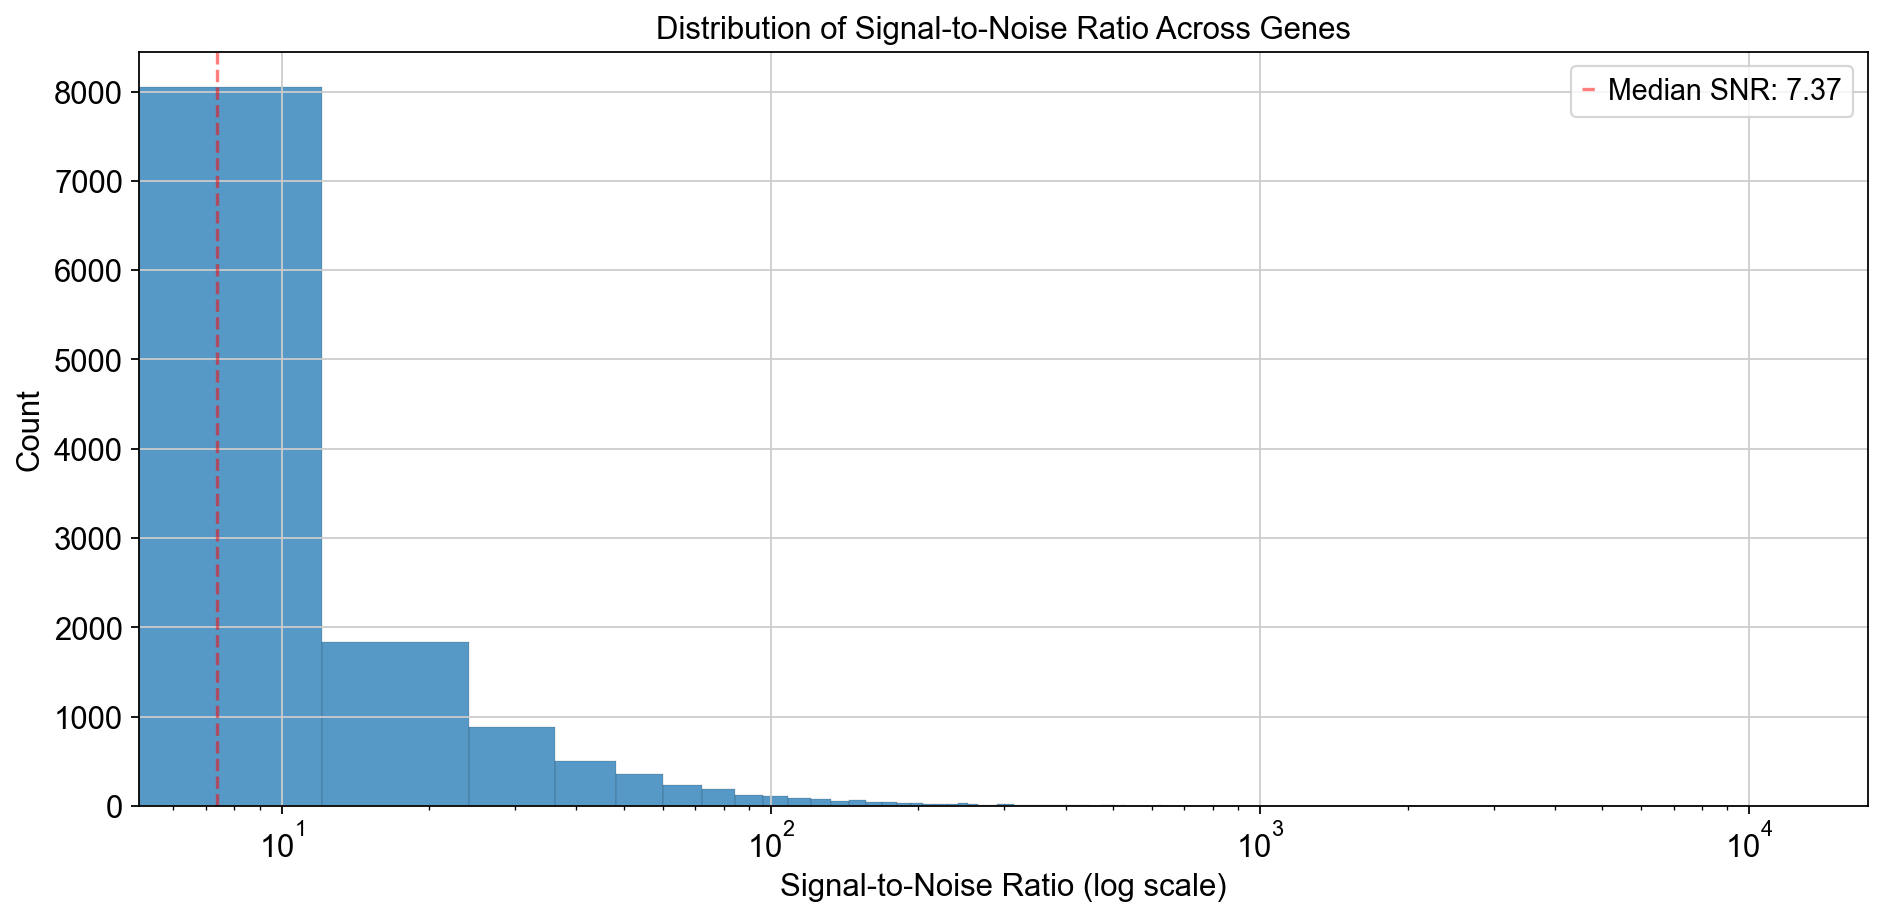


SNR Summary Statistics:
count    13040.000000
mean        31.187584
std        147.479245
min          0.000000
25%          2.547650
50%          7.373740
75%         22.914667
max      12050.220461
dtype: float64


In [12]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
sns.histplot(data=snr, bins=1000)

# Add log scale for x-axis since SNR values often span several orders of magnitude
plt.xscale('log')

# Customize the plot
plt.title('Distribution of Signal-to-Noise Ratio Across Genes')
plt.xlabel('Signal-to-Noise Ratio (log scale)')
plt.ylabel('Count')

# Add grid for better readability
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Optional: Add vertical line at median
plt.axvline(snr.median(), color='r', linestyle='--', alpha=0.5, label=f'Median SNR: {snr.median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSNR Summary Statistics:")
print(snr.describe())

In [13]:
# Select genes with high SNR
high_snr_genes = snr[snr > 100]

# Print number of selected genes
print(f"Number of genes with great SNR: {len(high_snr_genes)}")

# Create filtered dataframe with only high SNR genes
df_filtered = df[high_snr_genes.index]

# Optional: Display first few rows and shape of filtered dataframe
print(f"\nShape of filtered dataframe: {df_filtered.shape}")
print("\nFirst few rows of filtered dataframe:")
print(df_filtered.head())

Number of genes with great SNR: 851

Shape of filtered dataframe: (65888, 851)

First few rows of filtered dataframe:
             CHRM3      RYR2      RXRG       TNR   B3GALT2      SYT2  \
annotated                                                              
126        0.00000  1.301712  1.301712  0.000000  1.301712  0.849207   
104        1.43998  0.000000  0.000000  0.729256  0.729256  0.000000   
129        0.00000  1.052499  0.000000  1.052499  0.000000  0.000000   
129        0.00000  0.000000  0.000000  0.000000  0.571013  0.000000   
115        0.00000  0.589141  0.000000  0.589141  0.000000  0.000000   

            KLHDC8A    PLXNA2     KCNH1  PTPN14  ...   ZCCHC18  IL1RAPL2  \
annotated                                        ...                       
126        0.000000  0.000000  0.000000     0.0  ...  0.849207       0.0   
104        0.000000  1.439980  0.000000     0.0  ...  1.666602       0.0   
129        0.000000  1.553841  0.000000     0.0  ...  1.886222       0.0 

In [14]:
# Split into mouse and macaque dataframes
ms_sub_df = df_filtered[df_filtered.index < 200]
mk_sub_df = df_filtered[df_filtered.index >= 200]

# Print information about the split
print(f"Mouse dataframe shape: {ms_sub_df.shape}")
print(f"Macaque dataframe shape: {mk_sub_df.shape}")

# Optional: Display first few rows of each
print("\nFirst few rows of mouse dataframe:")
print(ms_sub_df.head())
print("\nFirst few rows of macaque dataframe:")
print(mk_sub_df.head())

Mouse dataframe shape: (35697, 851)
Macaque dataframe shape: (30191, 851)

First few rows of mouse dataframe:
             CHRM3      RYR2      RXRG       TNR   B3GALT2      SYT2  \
annotated                                                              
126        0.00000  1.301712  1.301712  0.000000  1.301712  0.849207   
104        1.43998  0.000000  0.000000  0.729256  0.729256  0.000000   
129        0.00000  1.052499  0.000000  1.052499  0.000000  0.000000   
129        0.00000  0.000000  0.000000  0.000000  0.571013  0.000000   
115        0.00000  0.589141  0.000000  0.589141  0.000000  0.000000   

            KLHDC8A    PLXNA2     KCNH1  PTPN14  ...   ZCCHC18  IL1RAPL2  \
annotated                                        ...                       
126        0.000000  0.000000  0.000000     0.0  ...  0.849207       0.0   
104        0.000000  1.439980  0.000000     0.0  ...  1.666602       0.0   
129        0.000000  1.553841  0.000000     0.0  ...  1.886222       0.0   
129  

In [15]:
# transform the index back to cell type names
mk_sub_df.index = mk_sub_df.index - 201
mk_sub_df.index = mk_sub_df.index.map(mk_rgc_mapping)
mk_sub_df

,CHRM3,RYR2,RXRG,TNR,B3GALT2,SYT2,KLHDC8A,PLXNA2,KCNH1,PTPN14,...,ZCCHC18,IL1RAPL2,RTL4,PLS3,ZCCHC12,PGRMC1,SLC25A5,NDUFA1,GRIA3,LDOC1
annotated,,,,,,,,,,,,,,,,,,,,,
MG_OFF,0.0,3.311033,0.814383,0.0,0.0,0.487900,0.0,1.060105,0.000000,0.000000,...,0.0,1.060105,0.0,0.000000,0.0,0.487900,0.000000,2.216546,0.814383,1.060105
MG_OFF,0.0,3.129190,1.182006,0.0,0.0,0.000000,0.0,0.000000,0.561692,0.919196,...,0.0,2.949022,0.0,0.000000,0.0,0.561692,0.000000,2.144335,1.708707,0.919196
PG_OFF,0.0,3.235928,0.882208,0.0,0.0,0.303106,0.0,0.723760,0.303106,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.303106,0.303106,2.741895,1.513054,0.882208
PG_ON,0.0,3.021020,1.645034,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.872852,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.331695,0.000000,0.000000
MG_ON,0.0,3.537583,1.798247,0.0,0.0,1.061134,0.0,0.000000,0.488507,0.815260,...,0.0,1.798247,0.0,0.000000,0.0,1.061134,0.488507,2.655178,0.815260,1.061134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MG_ON,0.0,2.493919,1.169918,0.0,0.0,0.908723,0.0,0.000000,0.000000,0.000000,...,0.0,1.821971,0.0,0.000000,0.0,0.908723,0.554216,2.553283,1.169918,1.169918
MG_OFF,0.0,3.253084,0.991651,0.0,0.0,0.991651,0.0,0.756335,0.448031,0.756335,...,0.0,2.187531,0.0,0.448031,0.0,0.448031,0.000000,2.413598,1.341855,0.448031
MG_OFF,0.0,3.285936,1.205808,0.0,0.0,1.205808,0.0,0.000000,1.736759,1.506116,...,0.0,3.093544,0.0,0.000000,0.0,2.217908,0.000000,2.217908,1.736759,0.774602


In [16]:
# transform the index back to cell type names
ms_sub_df.index = ms_sub_df.index - 100
ms_sub_df

,CHRM3,RYR2,RXRG,TNR,B3GALT2,SYT2,KLHDC8A,PLXNA2,KCNH1,PTPN14,...,ZCCHC18,IL1RAPL2,RTL4,PLS3,ZCCHC12,PGRMC1,SLC25A5,NDUFA1,GRIA3,LDOC1
annotated,,,,,,,,,,,,,,,,,,,,,
26,0.000000,1.301712,1.301712,0.000000,1.301712,0.849207,0.000000,0.000000,0.000000,0.0,...,0.849207,0.000000,0.000000,1.301712,0.0,0.849207,0.000000,0.000000,0.000000,0.0
4,1.439980,0.000000,0.000000,0.729256,0.729256,0.000000,0.000000,1.439980,0.000000,0.0,...,1.666602,0.000000,0.729256,1.439980,0.0,0.000000,2.007035,1.851236,1.439980,0.0
29,0.000000,1.052499,0.000000,1.052499,0.000000,0.000000,0.000000,1.553841,0.000000,0.0,...,1.886222,0.000000,0.658763,0.658763,0.0,1.553841,1.334265,2.018471,1.886222,0.0
29,0.000000,0.000000,0.000000,0.000000,0.571013,0.000000,0.571013,0.000000,1.197003,0.0,...,2.466475,0.000000,0.571013,0.571013,0.0,1.726396,2.163392,1.579041,1.406156,0.0
15,0.000000,0.589141,0.000000,0.589141,0.000000,0.000000,1.225926,0.957386,0.000000,0.0,...,1.889654,0.000000,0.000000,1.225926,0.0,1.889654,2.199931,2.285117,1.437405,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.333000,0.333000,0.948018,1.215175,0.781818,0.000000,1.215175,0.000000,0.000000,0.0,...,1.814323,0.582381,0.000000,0.948018,0.0,2.140984,1.876723,1.599686,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.890148,0.000000,0.000000,0.0,...,1.890148,0.000000,0.000000,0.000000,0.0,0.000000,1.651589,0.877586,0.877586,0.0
16,1.539249,1.420231,0.420690,0.943531,1.128834,0.000000,1.420231,1.741713,0.000000,0.0,...,0.943531,0.000000,0.000000,0.420690,0.0,1.128834,1.645596,0.715899,0.420690,0.0


In [17]:
# Calculate mean expression per cell type for both species
ms_type_means = ms_sub_df.groupby(ms_sub_df.index).mean()
mk_type_means = mk_sub_df.groupby(mk_sub_df.index).mean()

# Convert to torch tensors
ms_tensor = torch.tensor(ms_type_means.values, dtype=torch.float32)
mk_tensor = torch.tensor(mk_type_means.values, dtype=torch.float32)

# Normalize the vectors
ms_norm = F.normalize(ms_tensor, dim=1)
mk_norm = F.normalize(mk_tensor, dim=1)

# Compute cosine similarity (1 - cosine distance)
distance_matrix = pd.DataFrame(
    1- torch.mm(mk_norm, ms_norm.t()).numpy(),
    index=mk_type_means.index,
    columns=ms_type_means.index
)

In [18]:
# Define the desired order for plotting cell types
desired_order = [
    "MG_OFF",    # MG_OFF
    "PG_OFF",    # PG_OFF
    "PG_ON",     # PG_ON
    "MG_ON",     # MG_ON
    "fRGC5",     # fRGC5
    "fRGC6",     # fRGC6
    "fRGC7",     # fRGC7
    "fRGC8",     # fRGC8
    "fRGC9",     # fRGC9
    "fRGC10",    # fRGC10
    "fRGC11",    # fRGC11
    "fRGC12",    # fRGC12
    "fRGC13",    # fRGC13
    "fRGC14",    # fRGC14
    "fRGC15",    # fRGC15
    "fRGC16"     # fRGC16
]

In [19]:
def plot_transport_comparison(distance_matrix, mesh_lr=1.0, n_mesh_iters=4,
                            temperature=1.0, n_sh_iters=5):
    """
    Plot and compare regular Sinkhorn vs sparse Sinkhorn transport matrices.
    """
    # Regular Sinkhorn
    regular_transport = compute_regular_transport(
        distance_matrix, 
        temperature=temperature,
        n_sh_iters=n_sh_iters
    )
    
    # Sparse Sinkhorn with MESH
    sparse_transport = compute_sparse_transport(
        distance_matrix,
        mesh_lr=mesh_lr,
        n_mesh_iters=n_mesh_iters,
        temperature=temperature,
        n_sh_iters=n_sh_iters
    )
    
    # Plot both
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
    
    sns.heatmap(regular_transport, cmap='bwr', square=True, annot=False,
                fmt='.3f', ax=ax1)
    ax1.set_title('Regular Sinkhorn Transport', fontsize=12)
    ax1.set_xlabel('Mouse RGC Types', fontsize=12)
    ax1.set_ylabel('Macaque RGC Types', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=12)
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
    
    sns.heatmap(sparse_transport, cmap='bwr', square=True, annot=False,
                fmt='.3f', ax=ax2)
    ax2.set_title('Sparse Sinkhorn Transport (with MESH)', fontsize=12)
    ax2.set_xlabel('Mouse RGC Types', fontsize=12)
    ax2.set_ylabel('Macaque RGC Types', fontsize=12)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=12)
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)
    
    plt.tight_layout()
    plt.savefig('./Plots/ot_rgcs.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print sparsity comparison
    regular_sparsity = (regular_transport < 0.001).sum().sum() / regular_transport.size
    sparse_sparsity = (sparse_transport < 0.001).sum().sum() / sparse_transport.size
    print(f"\nSparsity comparison (percentage of elements < 0.01):")
    print(f"Regular Sinkhorn: {regular_sparsity:.1%}")
    print(f"Sparse Sinkhorn: {sparse_sparsity:.1%}")
    return regular_transport, sparse_transport

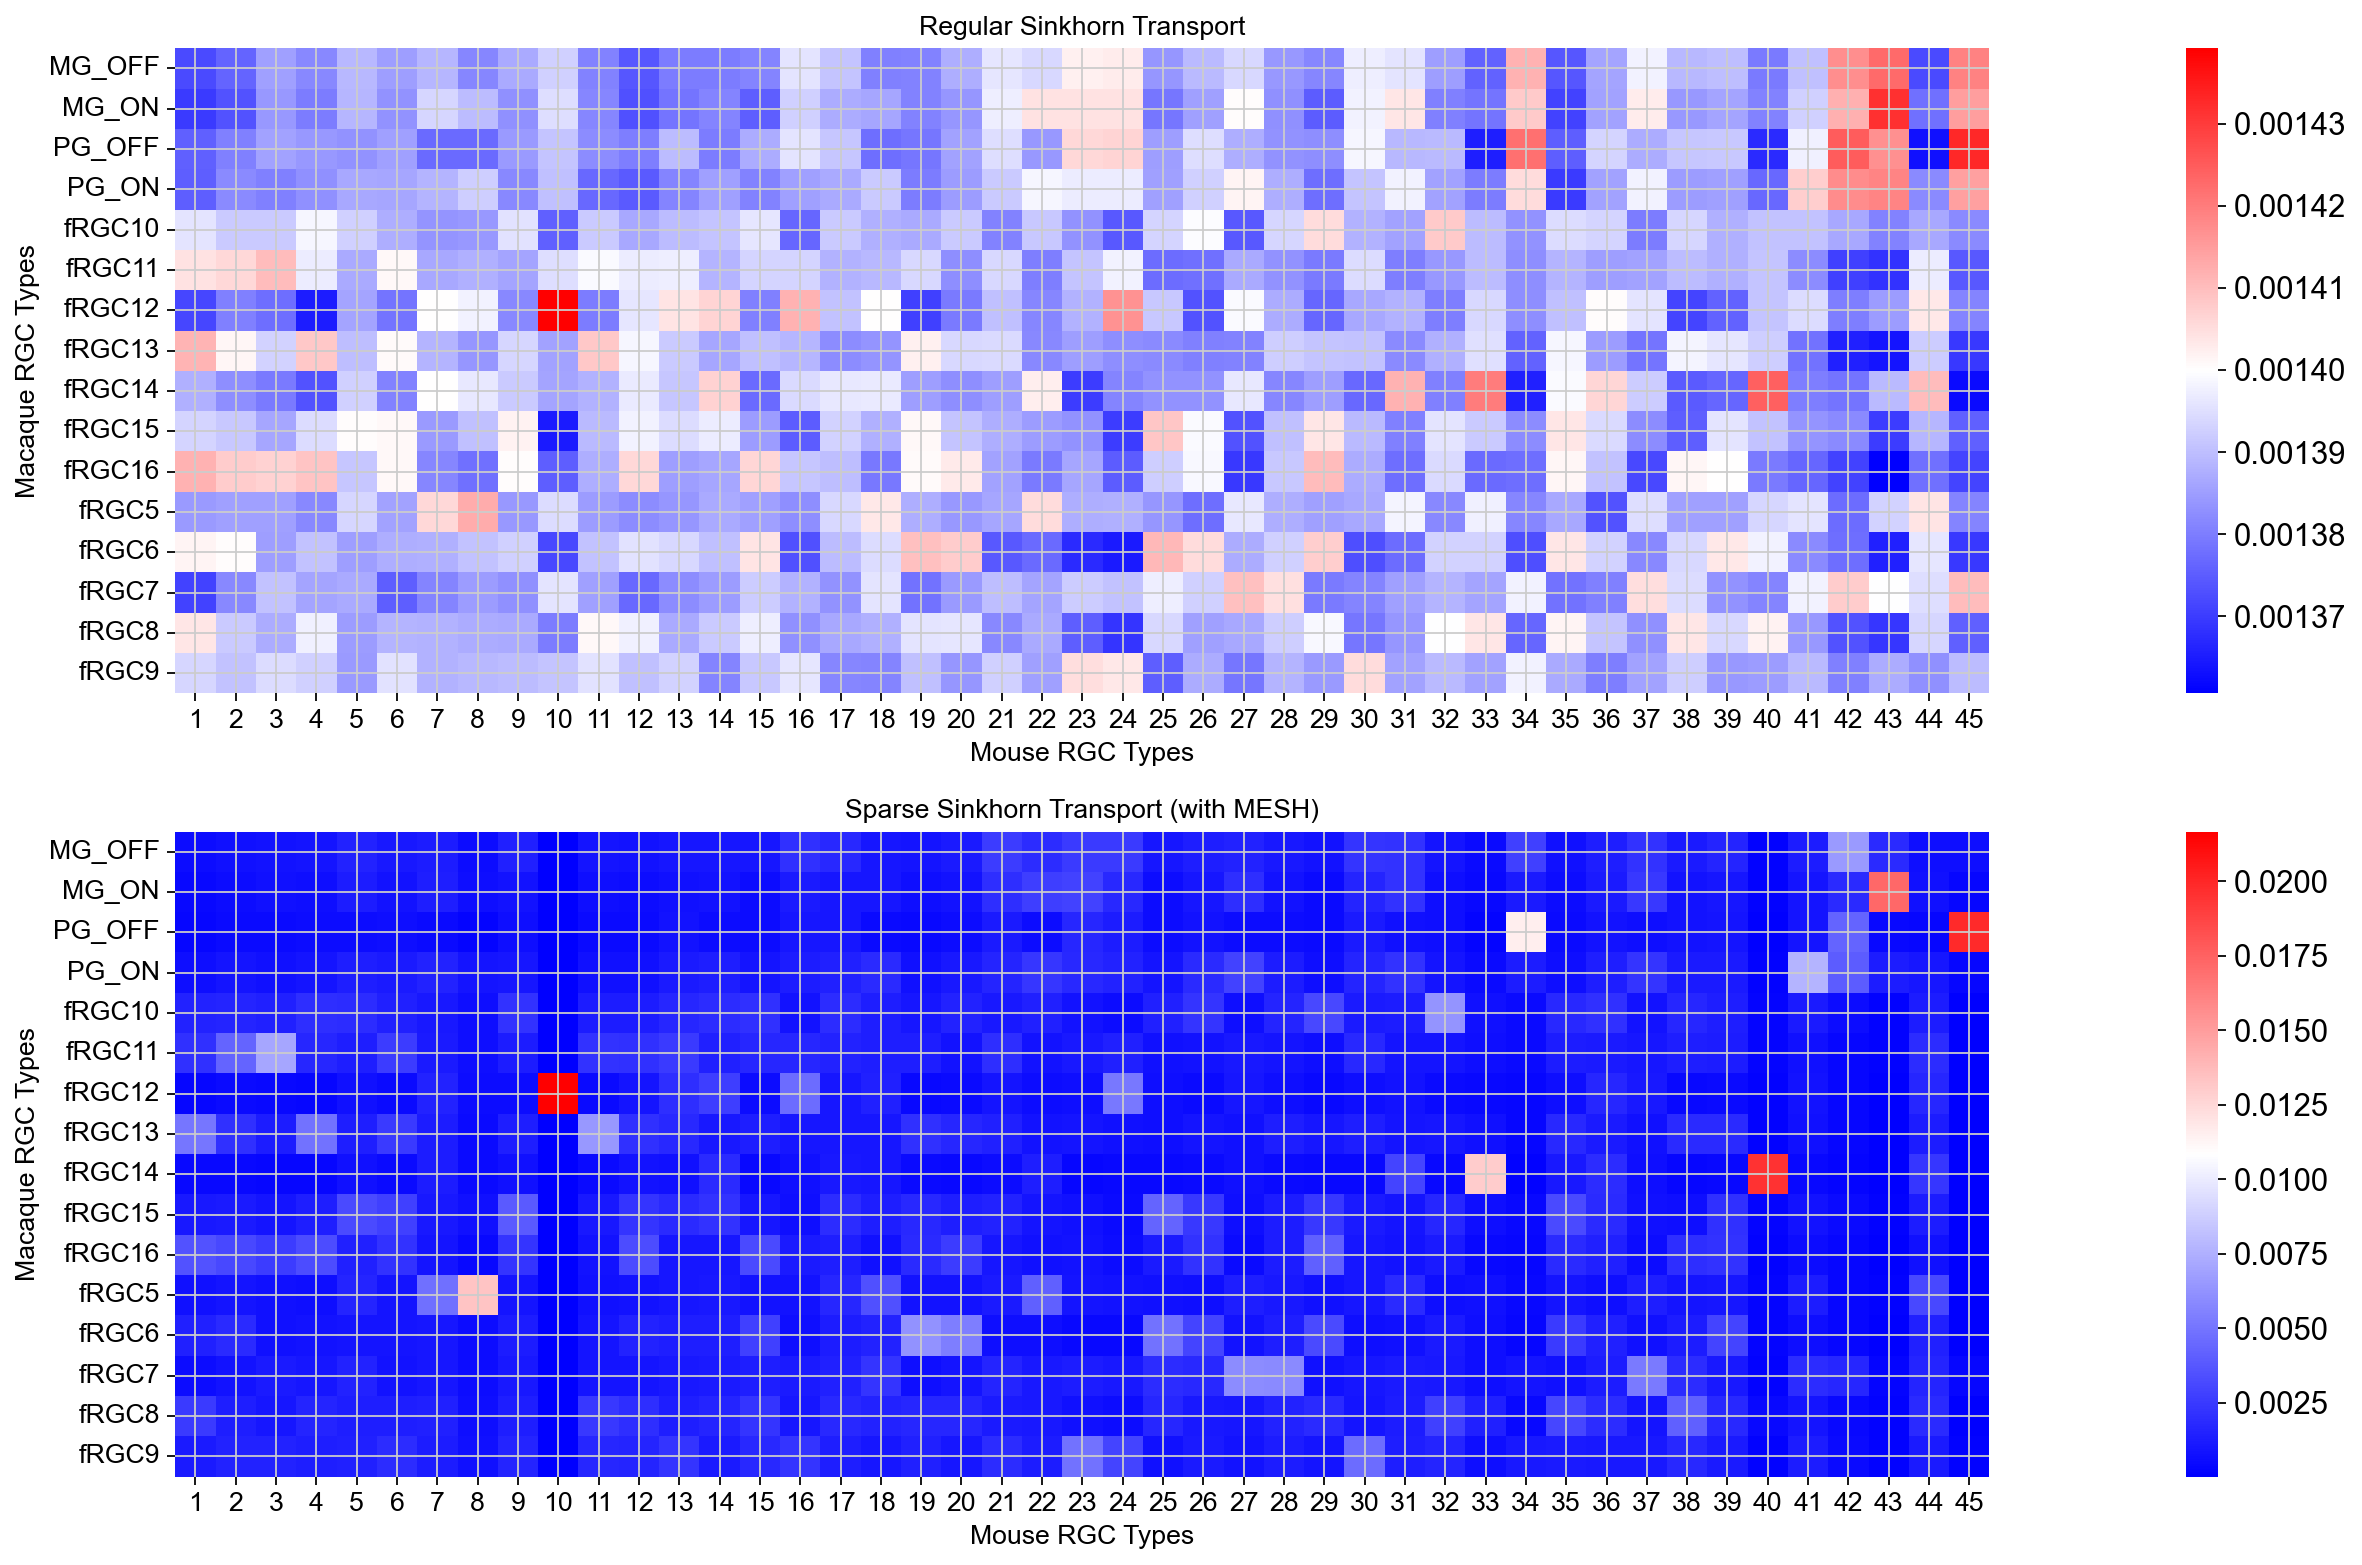


Sparsity comparison (percentage of elements < 0.01):
Regular Sinkhorn: 0.0%
Sparse Sinkhorn: 49.4%


In [20]:
# Visualize comparison
regular_transport, sparse_transport = plot_transport_comparison(
    distance_matrix,
    mesh_lr=5.0,
    n_mesh_iters=4,
    temperature=1.0,
    n_sh_iters=5
)

In [23]:
# for sparse_transport
matrix = sparse_transport

# Ensure the matrix is normalized
if not np.isclose(matrix.values.sum(), 1.0):
    matrix = matrix / matrix.values.sum()

# Calculate metrics
sparseness = sparseness_score(matrix.values)
entropy_value = entropy(matrix.values)

# Print results
print("\nCorrespondence Matrix Evaluation Results:")
print("----------------------------------------")
print(f"Sparseness Score: {sparseness:.4f}")
print(f"Entropy: {entropy_value:.4f}")

# Additional information about the matrix
print("\nMatrix Information:")
print(f"Shape: {matrix.shape}")
print(f"Number of cells: {matrix.size}")
print(f"Number of cells with value > 0.001: {np.sum(matrix.values > 0.001)}")
print(f"Maximum value: {matrix.values.max():.4f}")

# Calculate density (opposite of sparseness)
density = 1 - sparseness
print(f"Density (1-sparseness): {density:.4f}")

# Top correspondences
alignment_scores = calculate_alignment_scores(matrix).flatten()
top_indices = np.argsort(alignment_scores)[-10:][::-1]  # Get indices of top 10 values
rows, cols = np.unravel_index(top_indices, matrix.shape)

print("\nTop 10 Strongest Correspondences:")
for i in range(len(top_indices)):
    row_name = matrix.index[rows[i]]
    col_name = matrix.columns[cols[i]]
    value = alignment_scores[top_indices[i]]
    print(f"{row_name} → {col_name}: {value:.4f}")



Correspondence Matrix Evaluation Results:
----------------------------------------
Sparseness Score: 0.4944
Entropy: 6.1427

Matrix Information:
Shape: (16, 45)
Number of cells: 720
Number of cells with value > 0.001: 364
Maximum value: 0.0217
Density (1-sparseness): 0.5056

Top 10 Strongest Correspondences:
fRGC12 → 10: 0.6616
PG_OFF → 45: 0.6060
fRGC14 → 40: 0.5967
MG_ON → 43: 0.5242
fRGC5 → 8: 0.4058
fRGC14 → 33: 0.3971
PG_OFF → 34: 0.3524
PG_ON → 41: 0.2345
fRGC11 → 3: 0.2156
MG_OFF → 42: 0.1995
